In [2]:
from triangulation import customCVX, cvxLP, exactLPSimplex
from utilities import simplexSample, min_distance, triangle_area, coverage
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from scipy.spatial import Delaunay
import datetime
import pickle
from matplotlib.colors import LightSource, Normalize, ListedColormap, BoundaryNorm
import matplotlib.tri as mtri
from scipy.io import loadmat
import einops

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Roman Modern",
    "font.size"  : 5
})

%matplotlib inline

## Verifying theoretical bound

In [ ]:
point_density = 20000
pad = 1.02

fig, ax = plt.subplots(1, 2, figsize=(5.14838, 1.5))

rhos = np.array([2 ** x for x in range(-32, 3)])
rhos.sort()
rhos = rhos[::-1]

d = 1
n = 10

use_saved = True

if use_saved:
    X = np.load("paper_triangle.npy")
else:
    X = np.random.rand(n, d)
    
    X -= X.mean(0)
    max_norm = np.linalg.norm(X, axis=1).max()
    X /= max_norm



tri = Delaunay(X)


area_fractions = np.zeros(len(tri.simplices))

for i, vertices in enumerate(tqdm(tri.simplices)):
    area_fractions[i] = triangle_area(X[vertices])
    
area_fractions /= area_fractions.sum()

points_per_triangle = np.zeros((len(tri.simplices)), dtype=int)

for i in range(points_per_triangle.shape[0]):
    points_per_triangle[i] = max(np.round(point_density * area_fractions[i]).astype(int), 1)

# update true number of points to account for 
n_total_points = points_per_triangle.sum().astype(int)
points = np.zeros((n_total_points, 2))
max_rhos = np.zeros(n_total_points)
true_rho_bound = np.zeros(n_total_points)

# make the triangles
idx = 0
for i, vertices in enumerate(tqdm(tri.simplices)):

    # find the max rho that identifies the vertices
    for point_i in range(points_per_triangle[i]):
        weights = simplexSample(3, 1).reshape(1, -1)
        p = weights @ X[vertices]
        points[idx] = p

        # find largest rho that identifies the support
        for rho in rhos:
            support, weights_r = customCVX(X, p, rho)
            if len(np.setdiff1d(support, vertices)) == 0 and len(np.intersect1d(support, vertices)) == 3:
                max_rhos[idx] = rho
                break

        # for plotting
        if max_rhos[idx] == 0.0:
            max_rhos[idx] = rhos[-1]


        # rho bound computation
        C = np.power(np.linalg.norm(p - X[vertices], axis=1), 2)
        Cmax = C.max()
        Cmin = C.min()

        dSy = min_distance(X[vertices], p)

        true_rho_bound[idx] = dSy / (Cmax - Cmin)
        
        if max_rhos[idx] < true_rho_bound[idx]:
            print(f"max: {max_rhos[idx]}")
            print(f"true: {true_rho_bound[idx]}")
        idx += 1


dot_size = 1
alpha = 0.5
vmax = max(np.log10(true_rho_bound).max(), np.log10(max_rhos).max())
vmin = min(np.log10(true_rho_bound).min(), np.log10(max_rhos).min())
sc = ax[0].scatter(points[:, 0], points[:, 1], c=np.log10(true_rho_bound), cmap=plt.cm.get_cmap("plasma"), s=dot_size, alpha=alpha, vmin=vmin, vmax=vmax)
ax[0].scatter(X[:, 0], X[:, 1], c="red", s=dot_size)
ax[0].triplot(X[:, 0], X[:, 1], tri.simplices, c='red', linewidth=0.5)

ax[0].set_xlim([X[:, 0].min() * pad, X[:, 0].max() * pad])
ax[0].set_title(r"Theoretical upper bound of $\rho$")
ax[0].axis("off")
ax[0].set_aspect("equal")


sc = ax[1].scatter(points[:, 0], points[:, 1], c=np.log10(max_rhos), cmap=plt.cm.get_cmap("plasma"), s=dot_size, alpha=alpha, vmin=vmin, vmax=vmax)
ax[1].scatter(X[:, 0], X[:, 1], c="red", s=dot_size)
ax[1].triplot(X[:, 0], X[:, 1], tri.simplices, c='red', linewidth=0.5)

ax[1].set_xlim([X[:, 0].min()*pad, X[:, 0].max()*pad])
ax[1].set_aspect("equal")
ax[1].set_title(r"Empirical $\rho$")
ax[1].axis("off")

fig.subplots_adjust(left=0.0, right=0.9, bottom=0.0, wspace=0.0, hspace=0.0)
cbar_ax = fig.add_axes([0.9, 0.05, 0.01, 0.8])
fig.colorbar(sc, cax=cbar_ax)


dtstr = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
fig.savefig(f"images/rho_bound_2D_triangulation{dtstr}.pdf")

## Solution path examples

In [ ]:
use_saved = True
pad = 1.05

# make points 
if use_saved:
    X = np.load("paper_triangle.npy")
else:
    X = np.random.rand(n, d)
    
    X -= X.mean(0)
    max_norm = np.linalg.norm(X, axis=1).max()
    X /= max_norm
    
tri = Delaunay(X)

ps = np.array([[0.0, 0.2], 
              [0.5, 0.0],
              [-0.25, -0.1],
               [0.25, -0.3]])

# max and min rho may need to change depending on p
num_rhos = 300
rhos = np.linspace(1e-5, 10, num_rhos)[::-1]
solutions = np.zeros((num_rhos, 2))

 # plot different solutions for maximal rho resulting in nearest neighbor to smallest resulting in delaunay triangulation and perfect identification
fig, ax = plt.subplots(1,4,figsize=(5.14838, 0.75), dpi=600)
fig2, ax2 = plt.subplots(2,2,figsize=(5.14838, 3), dpi=600)
dot_size = 5

# compute the solution path
# crude logic to plot the relavant solution path 
# mostly so the colors look nice and uniform over the full range :) 

for idx, p in enumerate(ps):
    curr_ax = ax2[idx //2, idx %2]
    first_i = 0
    last_i = num_rhos-1
    tol = 1e-5
    first_i_found = False
    last_i_found = False
    for i in range(num_rhos):
        support, x = customCVX(X, p.reshape(1,-1), rhos[i])
        if not first_i_found and support.size == 2:
            first_i = max(0, i-1)
            first_i_found = True
        
        solutions[i] = x.reshape(1,-1) @ X
        if not last_i_found and np.linalg.norm(solutions[i] - p) < tol:
            last_i = i+1
            last_i_found = True
    
    
   
    
    ax[idx].scatter(X[:, 0], X[:, 1], c="black", s=dot_size)
    ax[idx].triplot(X[:, 0], X[:, 1], tri.simplices, c='black', linewidth=0.5)
    ax[idx].scatter(p[0], p[1], c='r', s=dot_size)
    ax[idx].axis('off')
    sc = ax[idx].scatter(solutions[first_i:last_i,0], solutions[first_i:last_i,1], c=rhos[first_i:last_i], s=dot_size, cmap='plasma')
    min_rho, max_rho = rhos[first_i:last_i].min(), rhos[first_i:last_i].max()
    mid_rho = (min_rho + max_rho) / 2
    cbar = fig.colorbar(sc, ax=ax[idx], ticks=[min_rho, mid_rho, max_rho])
    cbar.ax.set_yticklabels([f'{min_rho:.2f}', f'{mid_rho:.2f}', f'{max_rho:.2f}'])
    
    
    ax[idx].set_xlim([X[:, 0].min() * pad, X[:, 0].max() * pad])
    ax[idx].set_aspect("equal")
    
    ###### 2x2 plot ######
    curr_ax.scatter(X[:, 0], X[:, 1], c="black", s=dot_size)
    curr_ax.triplot(X[:, 0], X[:, 1], tri.simplices, c='black', linewidth=0.5)
    curr_ax.scatter(p[0], p[1], c='r', s=dot_size)
    curr_ax.axis('off')
    sc = curr_ax.scatter(solutions[first_i:last_i,0], solutions[first_i:last_i,1], c=rhos[first_i:last_i], s=dot_size, cmap='plasma')
    min_rho, max_rho = rhos[first_i:last_i].min(), rhos[first_i:last_i].max()
    mid_rho = (min_rho + max_rho) / 2
    cbar = fig.colorbar(sc, ax=curr_ax, ticks=[min_rho, mid_rho, max_rho])
    cbar.ax.set_yticklabels([f'{min_rho:.2f}', f'{mid_rho:.2f}', f'{max_rho:.2f}'])
    
    
    curr_ax.set_xlim([X[:, 0].min() * pad, X[:, 0].max() * pad])
    curr_ax.set_aspect("equal")

fig.subplots_adjust(left=0, right=0.96, top=0.96, bottom=0.05)
fig.savefig("images/2D_solution_path_v2.pdf")

fig2.subplots_adjust(left=0, right=0.96, top=0.96, bottom=0.05)
fig2.savefig("images/2D_solution_path_v2_2x2.pdf")

## Solution path in higher dimensions

In [ ]:
d = 5
n = 100

use_saved = True

if use_saved:
    X = np.load("high_d_X.npy")
    ys = np.load("high_d_ys.npy")
else:
    X = np.random.rand(n, d)
        
    X -= X.mean(0)
    max_norm = np.linalg.norm(X, axis=1).max()
    X /= max_norm
    
    ys = np.zeros((4, d))
    for i in range(4):
        weights = simplexSample(n, 1)
    
        ys[i] = weights.reshape(1,-1) @ X 
    

fig, ax = plt.subplots(1, 4, figsize=(5.14838, 1.25), dpi=600)

colors = ["#0077bb", "#33bbee", "#009988", "#ee7733", "#cc3311", "#ee3377", "#bbbbbb"]

for ax_idx in range(4):
    
    
    
    num_rhos = 500
    rhos = np.linspace(1e-7, 50, num_rhos)
    
    xs = np.zeros((num_rhos, n))
    last_i = num_rhos
    last_i_found = False
    for i in range(num_rhos):
        support, x = customCVX(X, ys[ax_idx].reshape(1,-1), rhos[i])
        xs[i] = x.reshape(-1)
        
        if not last_i_found and support.size == 1:
            last_i = i+1
            last_i_found = True
            break
    
    used_vertices = (xs > 1e-3).sum(0) > 0
    xs = xs[:, used_vertices]
    cmap = plt.colormaps["plasma"]
    norm = Normalize(0, xs.shape[1]-1)
    for i in range(xs.shape[1]):
        ax[ax_idx].plot(rhos[:last_i], xs[:last_i, i], linewidth=0.5, c=cmap(norm(i)))
        ax[ax_idx].set_xticks([0.0, rhos[last_i-1]])
        ax[ax_idx].set_xticklabels(["0.0", f"{rhos[last_i-1]:.2f}"])
        
    ax[ax_idx].set_xlabel(r"$\rho$")
ax[0].set_ylabel(r"$w_i$")

fig.tight_layout(pad=0.1)
fig.savefig(f"images/higher_d={d}_solution_path.pdf")

## Scaling data visualization 

requires scaling data computed in `scaling_all.py`

In [ ]:
time = "2023-10-16_11:03:26"
with open(f"data/{time}_runtime_data.pkl", 'rb') as f:
    data = pickle.load(f)


solve_timesQP = data["QP"]
ns = data["ns"]
ds = data["ds"]
solve_timesLP = data["LP"]
solve_timesExactLP = data["ExactLP"]
dSparse_solve_times = data["DelaunaySparse"]

colors = ['#eece65', '#f1b876', '#f4a084', '#f48791', '#f46c9d', '#f24aa8', '#ef00b3']

########### 2 x 2 plot ##############
fig, ax = plt.subplots(2,2, figsize=(5.14838, 1.1*5.14838))

for n_idx in range(0, 7, 2):
    n = ns[n_idx]
    # pick color
    c = colors[n_idx]

    log_x = np.log(ds)

    # LP times
    # fit line of best fit
    log_y = np.log(solve_timesLP[n_idx].mean(axis=1))
    coefficients = np.polyfit(log_x, log_y, 1)
    a = coefficients[0]
    b = np.exp(coefficients[1])

    # plot cvx LP times
    ax[0, 0].loglog(ds, solve_timesLP[n_idx].mean(axis=1), color=c, linestyle=":",
              label=fr'Cvx Hull LP (n={n})')  # , ${b:.3f}x^{{{a:.3f}}}$')
    ax[0, 0].fill_between(ds, solve_timesLP[n_idx].mean(axis=1) + solve_timesLP[n_idx].std(axis=1),
                    solve_timesLP[n_idx].mean(axis=1) - solve_timesLP[n_idx].std(axis=1), color=c, alpha=0.3)

    # plot dsparse times
    log_y = np.log(dSparse_solve_times[n_idx].mean(axis=1))
    coefficients = np.polyfit(log_x, log_y, 1)
    a = coefficients[0]
    b = np.exp(coefficients[1])

    ax[0, 1].loglog(ds, dSparse_solve_times[n_idx].mean(axis=1), linestyle='--', color=c, label=fr'DelaunaySparse (n={n})')#, ${b:.3f}x^{{{a:.3f}}}$')
    ax[0, 1].fill_between(ds, dSparse_solve_times[n_idx].mean(axis=1) + dSparse_solve_times[n_idx].std(axis=1), dSparse_solve_times[n_idx].mean(axis=1) - dSparse_solve_times[n_idx].std(axis=1), color=c, alpha=0.3)


    # Exact LP times
    # fit line of best fit
    log_y = np.log(solve_timesExactLP[n_idx].mean(axis=1))
    coefficients = np.polyfit(log_x, log_y, 1)
    a = coefficients[0]
    b = np.exp(coefficients[1])

    # plot (E) times
    ax[1, 0].loglog(ds, solve_timesExactLP[n_idx].mean(axis=1), color=c,
              linestyle="dashdot", label=fr'(E) (n={n})')#, ${b:.3f}x^{{{a:.3f}}}$')
    ax[1, 0].fill_between(ds, solve_timesExactLP[n_idx].mean(axis=1) + solve_timesExactLP[n_idx].std(axis=1),
                    solve_timesExactLP[n_idx].mean(axis=1) - solve_timesExactLP[n_idx].std(axis=1), color=c, alpha=0.3)

    # fit line of best fit
    log_y = np.log(solve_timesQP[n_idx].mean(axis=1))
    coefficients = np.polyfit(log_x, log_y, 1)
    a = coefficients[0]
    b = np.exp(coefficients[1])

    # plot (R) times
    l, = ax[1, 1].loglog(ds, solve_timesQP[n_idx].mean(axis=1), c=c, label=fr'n={n}')  # , ${b:.3f}x^{{{a:.3f}}}$')
    ax[1, 1].fill_between(ds, solve_timesQP[n_idx].mean(axis=1) + solve_timesQP[n_idx].std(axis=1),
                    solve_timesQP[n_idx].mean(axis=1) - solve_timesQP[n_idx].std(axis=1), alpha=0.3, color=c)



ax[0, 0].set_title("Convex Hull LP")
ax[0, 1].set_title("DelaunaySparse")
ax[1, 0].set_title("(E)")
ax[1, 1].set_title(r"(R), $\rho=10^{-7}$")


ax[1, 0].set_xlabel(r"$d$")
ax[1, 1].set_xlabel(r"$d$")

ax[0, 0].set_ylabel("Time (s)")
ax[1, 0].set_ylabel("Time (s)")

y_min = min([ax[0, 0].get_ylim()[0], ax[0, 1].get_ylim()[0], ax[1, 0].get_ylim()[0], ax[1, 1].get_ylim()[0]])
y_max = max([ax[0, 0].get_ylim()[1], ax[0, 1].get_ylim()[1], ax[1, 0].get_ylim()[1], ax[1, 1].get_ylim()[1]])

ax[0, 0].set_ylim([y_min, y_max])
ax[0, 1].set_ylim([y_min, y_max])
ax[1, 0].set_ylim([y_min, y_max])
ax[1, 1].set_ylim([y_min, y_max])

# Adjust the main plot to make space for the legend axis on the right
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.99)

# Add a new axes for the legend with appropriate dimensions
legend_ax = fig.add_axes([0.0, 0.0, 1.0, 0.07])

handles, labels = ax[1, 1].get_legend_handles_labels()
legend_ax.legend(handles, labels, loc="lower center", ncol=4, frameon=False)

# Hide the axis lines and ticks of the legend axis
legend_ax.axis('off')


fig.savefig(f"images/scaling2x2_{time}.pdf")

## Visualizing the Lower Convex Hull Approach

In [ ]:

d = 2
n = 10

use_saved = True

if use_saved:
    X = np.load("paper_triangle.npy")
else:
    X = np.random.rand(n, d)

    X -= X.mean(0)
    max_norm = np.linalg.norm(X, axis=1).max()
    X /= max_norm

max_x = X[:, 0].max()
min_x = X[:, 0].min()
max_y = X[:, 1].max()
min_y = X[:, 1].min()

y = np.array([0.7, 0.2]).reshape(1, -1)
other_y = np.array([0.0, 0.2]).reshape(1, -1)

# true triangle
support, ray_length, ct = cvxLP(X, y, return_objective=True)

# wrong triangle for plotting purposes
_, _, ct2 = cvxLP(X, other_y, return_objective=True)

ray_length = -ray_length
ray_intersect = -(-ct2[2] - ct2[0]*y[0,0] - ct2[1]*y[0,1])[0]

fig = plt.figure(dpi=600, figsize=(4,2.9))
ax = fig.add_subplot(111, projection='3d')
ls = LightSource(azdeg=270, altdeg=5)

vertices = np.zeros((X.shape[0], 3))
vertices[:, :2] = X
vertices[:, 2] = X[:, 0] ** 2 + X[:, 1] ** 2

triang = mtri.Triangulation(vertices[:,0], vertices[:,1])
linewidth = 0.15

ax.plot_trisurf(triang, vertices[:,2], antialiased=True, alpha=0.7, linewidth=linewidth, edgecolors="aliceblue", shade=True, lightsource=ls, color="dodgerblue")
ax.scatter(y[0, 0], y[0, 1], 0, zorder=1, c='black', s=2, alpha=0.7)
ax.scatter(y[0, 0], y[0, 1], ray_length, c='black', zorder=1, s=2, alpha=0.7)
ray1 = np.zeros((2, 3))
ray2 = np.zeros((2, 3))
ray1[0] = np.array([y[0, 0], y[0, 1], 0])
ray1[1] = np.array([y[0, 0], y[0, 1], ray_intersect])

ray2[0] = np.array([y[0, 0], y[0, 1], ray_intersect])
ray2[1] = np.array([y[0, 0], y[0, 1], ray_length])
ax.plot(ray1[:, 0], ray1[:, 1], ray1[:, 2], zorder=1, c="black", alpha=0.7, linewidth=1)
ax.plot(ray2[:, 0], ray2[:, 1], ray2[:, 2], zorder=5, c="black", alpha=0.7, linewidth=1)

# plot dashed red lines connecting the lifted points
for i in range(X.shape[0]):
    ray = np.zeros((2, 3))
    ray[0,:2] = X[i]
    ray[1] = vertices[i]
    ax.plot(ray[:, 0], ray[:, 1], ray[:, 2], zorder=1, c="salmon", alpha=0.7, linewidth=0.7, linestyle="--")

x_range = np.linspace(-0.1, max_x, 10)
y_range = np.linspace(-0.1, max_y, 10)
X, Y = np.meshgrid(x_range, y_range)
z = ct[0] * X + ct[1] * Y + ct[2]


x_range = np.linspace(-0.1, max_x, 10)
y_range = np.linspace(-0.1, max_y, 10)
X2, Y2 = np.meshgrid(x_range, y_range)
z2 = ct2[0] * X2 + ct2[1] * Y2 + ct2[2]

ax.plot_surface(X2, Y2, z2, alpha=0.7, color="tomato", shade=True, lightsource=ls,
                    zorder=1)
ax.plot_surface(X, Y, z, alpha=0.7, color='springgreen', shade=True, lightsource=ls,
                zorder=100)


x_range = np.linspace(min_x, max_x, 10)
y_range = np.linspace(min_y, max_y, 10)
X, Y = np.meshgrid(x_range, y_range)
ax.plot_surface(X,Y, 0*X, alpha=0.0, color="white", edgecolors="lightgray", shade=True, lightsource=ls, linewidth=linewidth)
ax.scatter(vertices[:,0], vertices[:,1], np.zeros(vertices.shape[0]), s=2, c="black", alpha=0.7)
ax.plot_trisurf(triang, np.zeros(vertices.shape[0]), alpha=0.0, linewidth=linewidth, edgecolors="black", shade=True, lightsource=ls, color="white")

ax.view_init(elev=19, azim=105)
ax.set_zlim([-0.1, 1])
ax.set_xlim([min_x+0.1, max_x-0.1])
ax.set_ylim([min_y, max_y])
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
fig.tight_layout(pad=-5)
fig.savefig("images/convex_hull_LP_visualized.pdf")
plt.show()

## Visibility walk

In [ ]:
if use_saved:
    X = np.load("paper_triangle.npy")
else:
    X = np.random.rand(n, d)

    X -= X.mean(0)
    max_norm = np.linalg.norm(X, axis=1).max()
    X /= max_norm
    
    
fig, ax = plt.subplots(1,1,figsize=(5.14838/2, 1.5), dpi=600)
    
dot_size = 2

y = np.array([-0.4, 0.2])
S_pos = np.array([-0.5, -0.25])
s = np.array([-0.35, -0.3])
line = np.stack([y, s], axis=0)
ax.triplot(X[:, 0], X[:, 1], tri.simplices, c='red', linewidth=0.2, zorder=0)
ax.scatter(X[:, 0], X[:, 1], c="black", s=dot_size, zorder=10)
ax.scatter(y[0], y[1], c='cyan', s=dot_size, zorder=10)
ax.plot(line[:, 0], line[:, 1], c='black', linewidth=0.5)

ax.annotate(r"$\mathbf{y}$", (y[0]+0.03, y[1]))
ax.annotate(r"$S$", (S_pos[0], S_pos[1]))
plt.plot()

triangles = np.zeros((3, 3), dtype=int)

triangles[0] = [2, 3, 9]
triangles[1] = [2, 0, 9]
triangles[2] = [4, 0, 9]
intersect_idxs = [0, 9, 2]
plt.plot(X[intersect_idxs, 0], X[intersect_idxs, 1], c="blue", linewidth=0.3)
colors = ['#ffe558', '#e6a1a6', '#ff0a80']

# Create a custom colormap
cmap = ListedColormap(colors)

# Create a 'norm' that maps one color to each triangle
norm = BoundaryNorm(boundaries=np.arange(len(colors)+1)-0.5, ncolors=len(colors))

# Create an array of integers, each corresponding to a triangle
color_mapping = np.arange(len(triangles))
plt.tripcolor(X[:,0], X[:, 1], facecolors=color_mapping, norm=norm, cmap=cmap, triangles = triangles, zorder=0)
ax.set_aspect("equal")
ax.axis("off")

fig.savefig("images/visibilitywalk.pdf")


## Comparing relaxed and exact problems for varying $\rho$

In [ ]:
# num points considered
n = 250

n_points = 50
points_per_simplex = 1
total_points = n_points * points_per_simplex


rhos = np.array([1.5**x for x in range(-32, 20)])
rhos.sort()

idxes = np.arange(n)

# iterate over simplices and generate points to then solve QP to identify vertices and compute runtime

colors = ['#eece65',  '#f4a084', '#f46c9d', '#ef00b3']

ds = [3, 9, 27, 81]
fig, ax = plt.subplots(1, 2, figsize=(5.14838, 5.14838/2))
accuracies = np.zeros((n_points, len(rhos)))
for d_idx, d in enumerate(tqdm(ds)):
    X = np.random.rand(n, d)
    c = colors[d_idx]

    accuracies = np.zeros((n_points, len(rhos)))
    l1error = np.zeros((n_points, len(rhos)))

    for array_idx in tqdm(range(n_points)):

        # get simplex unclear what type of randomness this is
        # first sample a point in the convex hull of
        weights = simplexSample(n, 1).reshape(1, -1)

        p = weights @ X


        # get vertices of a simplex in the triangulation
        true_vertices, weights = exactLPSimplex(X, p)
        vertices = true_vertices.reshape(-1)
        true_weights = np.zeros(n)
        true_weights[vertices] = weights

        # solve QP for variety of rhos
        for k, rho in enumerate(rhos):
            support, weights_r = customCVX(X, p, rho)
            weights_r = weights_r.reshape(-1)
            support = support.reshape(-1)

            l1error[array_idx, k] = np.linalg.norm(weights_r - true_weights, 1)
            accuracies[ array_idx, k] = coverage(support, true_vertices)

    ax[0].loglog(rhos, l1error.mean(0), color=c)
    ax[0].fill_between(rhos, l1error.mean(0) - l1error.std(0), l1error.mean(0) + l1error.std(0),
                       alpha=0.3, color=c)


    # plot concentrations
    ax[1].semilogx(rhos, accuracies.mean(0), label=fr"$d={d}$", color=c)
    ax[1].fill_between(rhos, accuracies.mean(0) - accuracies.std(0), accuracies.mean(0) + accuracies.std(0),
                       alpha=0.3, color=c)

    ax[0].set_title(fr"Average $\ell_1$ Error")
    ax[0].set_xlabel(r"$\rho$")
    ax[0].set_ylabel(r"$\Vert \mathbf{w}_e - \mathbf{w}_{\rho} \Vert_1$")


    ax[1].set_title(f"Average Accuracy")
    ax[1].set_xlabel(r"$\rho$")
    ax[1].set_ylabel(r"$\frac{\vert I(S)\cap I(S') \vert}{\vert I(S)\cup I(S')\vert}$")
    ax[1].set_ylim([0, 1])

# Adjust the main plot to make space for the legend axis on the right
fig.subplots_adjust(bottom=0.2, top=0.925, left=0.1, right=0.99, wspace=0.25)

# Add a new axes for the legend with appropriate dimensions
legend_ax = fig.add_axes([0.0, 0.0, 1.0, 0.1])

handles, labels = ax[1].get_legend_handles_labels()
legend_ax.legend(handles, labels, loc="lower center", ncol=4, frameon=False)

# Hide the axis lines and ticks of the legend axis
legend_ax.axis('off')
# fig.tight_layout()
fig.savefig(f"images/d={ds}_n={n}_acc.pdf")

### Hyperspectral data

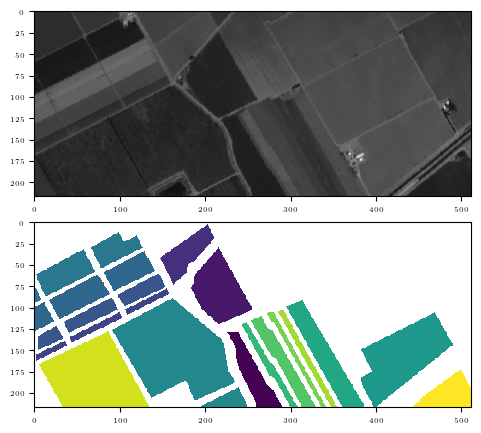

In [35]:
# Visualizes the hyperspectral data and labels 

fname = "hsi_datasets/Salinas_corrected.mat"
matname = "salinas_corrected"

data = loadmat(fname)[matname]

labels = loadmat("hsi_datasets/Salinas_gt.mat")["salinas_gt"]


labels = np.ma.masked_where(labels == 0, labels)

width = 5.14838 
height = width / 1.2
fig, ax = plt.subplots(2,1,figsize=(width, height))

ax[0].imshow(np.rot90(data[:,:,24]), cmap='gray')

ax[1].imshow(np.rot90(labels))
fig.tight_layout()
fig.savefig("images/salinas.pdf")